# Maternal Health Risk Prediction with Explainability
This notebook improves the prediction of maternal health risks using a Random Forest classifier and integrates SHAP for explainability.

### Key Features:
- **Improved Low-Risk Predictions:** Addressed class imbalance using SMOTE.
- **SHAP Explainability:** Added explanations for "High Risk" and "Mid Risk" predictions.
- **Manual Input:** Allows users to input custom values and predict their risk level.


In [65]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import joblib

In [66]:
# Load data
df = pd.read_csv('Dataset - Updated.csv')

# Separate features (X) and target (y)
X = df.drop(columns=['RiskLevel'])  # Drop only 'RiskLevel' from features
y = df['RiskLevel']  # Use only 'RiskLevel' as target

# Convert categorical target 'RiskLevel' to numerical values
y = y.map({'low risk': 0, 'high risk': 1})  # Only two categories: low risk and high risk

# Handle missing values for numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())

# Handle missing values for categorical columns (if any)
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0])  # Fill missing with mode

In [67]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
# Oversample the RiskLevel column
smote = SMOTE(random_state=42)
X_resampled, y_resampled_risk = smote.fit_resample(X_train, y_train)

In [70]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1
)

grid_search.fit(X_resampled, y_resampled_risk)
model = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


              precision    recall  f1-score   support

    Low Risk       0.99      0.99      0.99       148
   High Risk       0.98      0.99      0.98        86

    accuracy                           0.99       234
   macro avg       0.99      0.99      0.99       234
weighted avg       0.99      0.99      0.99       234



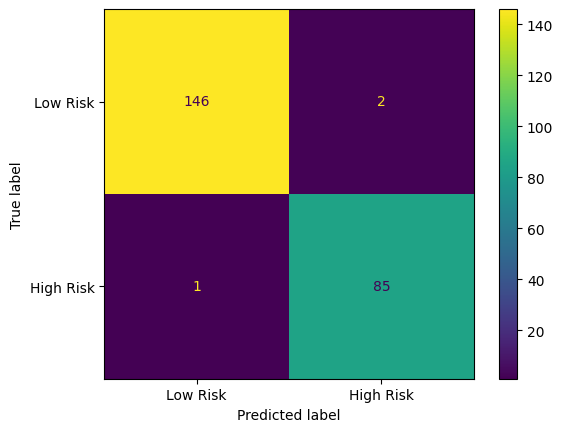

In [71]:
# Make predictions
y_pred = model.predict(X_test)

# Map numerical RiskLevel back to categorical values
risk_map = {0: 'Low Risk', 1: 'High Risk'}  # Only two categories
y_pred_risk = [risk_map[risk] for risk in y_pred]

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))

# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Low Risk', 'High Risk'])

In [79]:
# Example: Define manual_input_df with sample values
# Replace the dictionary below with actual input values as needed
manual_input_data = {
    col: [X_train.iloc[8][col]] for col in X_train.columns  # Use first row as template
}
manual_input_df = pd.DataFrame(manual_input_data)

# Predict RiskLevel for user input
prediction = model.predict(manual_input_df)

# Decode RiskLevel
risk_map = {0: 'Low Risk', 1: 'High Risk'}  # Only two categories
predicted_risk = risk_map[prediction[0]]

# Display the response
print(f"Predicted Risk Level: {predicted_risk}")

Predicted Risk Level: Low Risk
